In [1]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
raw_data = joblib.load("raw_data.job").real.swapaxes(1, 2)

In [54]:
class CNNDensityMatrix(nn.Module):
    def __init__(self, no_channels ,no_filters,kernel_window, timeseries_length=None):
        super(CNNDensityMatrix, self).__init__()
        self.kernel_window = kernel_window
        self.conv1 = nn.Conv1d(in_channels=no_channels, out_channels=no_filters, kernel_size=kernel_window)
        # self.fc0 = nn.Linear(kernel_window*no_channels, no_filters)
        self.fc1 = nn.Linear(no_filters, 256)
        self.fc2 = nn.Linear(256,no_channels)

    def forward(self, x):
        # x is of shape torch.Size([batch_size, num_features, kernel_window])
        
        # Apply convolution to the window
        aux = self.conv1(x).squeeze(-1)
        aux = nn.ReLU()(aux)
        # print(x.shape)
        # aux = self.fc0(x.flatten(-1))
        # aux = nn.ReLU()(aux)
        # Permute and apply fully connected layer
        # print(aux.shape)
        aux = self.fc1(aux)
        aux = nn.ReLU()(aux)
        aux = self.fc2(aux)
        
        # Squeeze the last dimension to remove the window size
        # output = aux.squeeze(-1)
        return aux

class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [55]:
def generate_sequence(model, initial_window, sequence_length):
    """
    Generates a sequence of the specified length using the given model and initial window.

    Args:
        model (YourModel): The trained model instance.
        initial_window (torch.Tensor): The initial window to start generating the sequence. 
                                       Shape should be (batch_size, num_features, kernel_window).
        sequence_length (int): The total length of the sequence to be generated.

    Returns:
        torch.Tensor: The generated sequence of shape (batch_size, num_features, sequence_length).
    """
    batch_size, num_features, kernel_window = initial_window.shape
    # Preallocate output tensor with the correct size
    final_output = torch.empty((batch_size, num_features, sequence_length), device=initial_window.device)

    # Fill in the initial part of the output sequence
    final_output[:, :, :kernel_window] = initial_window

    # Generate the rest of the sequence
    current_window = initial_window
    for i in range(sequence_length - kernel_window):
        # Get the model output for the current window
        output = model(current_window)
        
        # Place the output in the preallocated tensor
        final_output[:, :, i + kernel_window] = output
        
        # Update the current window by sliding one step forward
        current_window = torch.cat((current_window[:, :, 1:], output.unsqueeze(-1)), dim=2)
    
    return final_output

In [77]:
num_epochs = 5000  # Number of training epochs
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 64

kernel_window = 5



torch.autograd.set_detect_anomaly(False)
from tqdm.notebook import tqdm
import torch_optimizer as topt

opt_list = [torch.optim.Adam]

X_raw = raw_data[:,:,::100][:,:,:]
y_raw = raw_data[:,:,::100][:,:,:][:, :, kernel_window - 1 :]

# Split training and validation data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

dataset = DensityMatrixDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=len(X_train), shuffle=True)

test_dataset = DensityMatrixDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=len(X_val), shuffle=True)



model = CNNDensityMatrix(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

model = model.to(device)



criterion = lambda y_hat, y_true: nn.L1Loss()(y_hat, y_true)+nn.MSELoss()(y_hat, y_true)

optimizer = topt.DiffGrad(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(dataloader))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience = 200, verbose = True, threshold=1e-16)
progress_bar = tqdm(range(num_epochs), desc='Epoch')
minloss = 100
for epoch in progress_bar:
    running_loss = 0.0
    # progress_bar_epoch = tqdm(dataloader, desc='Batch')
    for i, data in enumerate(dataloader):
        X, y_true = data
        # y_true = X
        X = X.to(device)
        y_true = y_true.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        y_hat = generate_sequence(model, X[:,:,:kernel_window], X.shape[2])
        
        # Concatenate all outputs to get the final sequence
        # print(y_true.shape, y_hat.shape)
        d0_loss = criterion(y_true, y_hat[:,:,kernel_window-1:])
        # ft_loss = criterion(torch.fft.rfft(y_true).abs()[:,:,:10] , torch.fft.rfft(y_hat[:,:,kernel_window-1:]).abs()[:,:,:10] )

        loss = d0_loss #+ ft_loss*0.1
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        

        # Print statistics
        # running_loss += loss.item()
        
        # if i % 10 == 9:  # Print every 10 mini-batches
            # print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
            # minloss = running_loss if running_loss < minloss else minloss
            # running_loss = 0.0 if i!=(num_epochs-1) else running_loss
        # progress_bar_epoch.set_postfix(loss="{:.3e}".format(loss.item()))
        
    all_true = X_val

    all_preds = generate_sequence(model, tensor(X_val[:,:,:kernel_window]).to(device), X_val.shape[2]).clone().detach().cpu()
    val_loss = criterion(tensor(all_true), tensor(all_preds))
    scheduler.step(val_loss)
    progress_bar.set_postfix(loss="{:.3e}".format(val_loss.item()))
    
    


Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_82043/2623014243.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(tensor(all_true), tensor(all_preds))


Epoch 00881: reducing learning rate of group 0 to 5.0000e-03.
Epoch 02733: reducing learning rate of group 0 to 2.5000e-03.
Epoch 03243: reducing learning rate of group 0 to 1.2500e-03.
Epoch 04627: reducing learning rate of group 0 to 6.2500e-04.


In [74]:
all_preds = generate_sequence(model, tensor(X_val[:,:,:kernel_window]).to(device), X_val.shape[2]).detach().cpu().numpy()

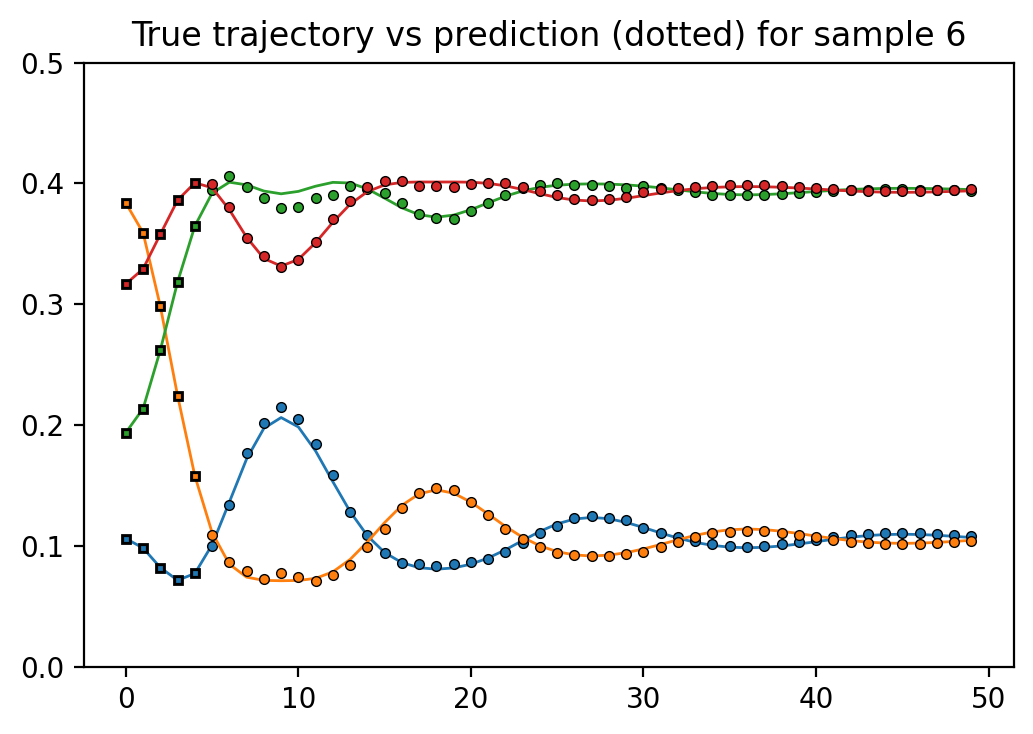

In [75]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()

i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(X_val[i][j], color=f'C{j}', lw=1)
    
    
    plt.plot(range(kernel_window), all_preds[i][j][:kernel_window], "s", color=f'k', ms=3)
    plt.plot(range(kernel_window), all_preds[i][j][:kernel_window], "s", color=f'C{j}', ms=1)
    
    plt.plot(range(kernel_window, len(all_preds[i][j]) ),all_preds[i][j][kernel_window:], ".", color=f'k', ms=6)
    plt.plot(range(kernel_window, len(all_preds[i][j]) ),all_preds[i][j][kernel_window:], ".", color=f'C{j}', ms=4)
    
    plt.ylim(0,0.5)
plt.title(f"True trajectory vs prediction (dotted) for sample {i}")
plt.show()

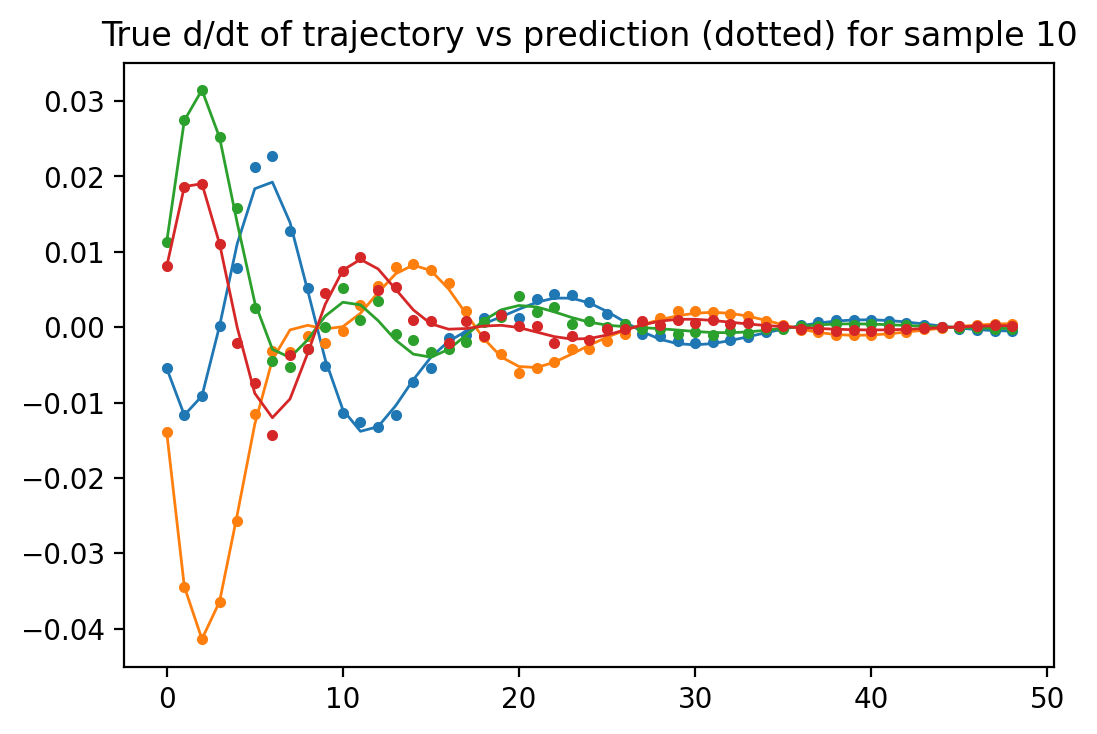

In [76]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()
i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(np.diff(X_val[i][j]), color=f'C{j}', lw=1)
    plt.plot(np.diff(all_preds[i][j]), ".", color=f'C{j}')
    # plt.ylim(0,1)
plt.title(f"True d/dt of trajectory vs prediction (dotted) for sample {i}")
plt.show()

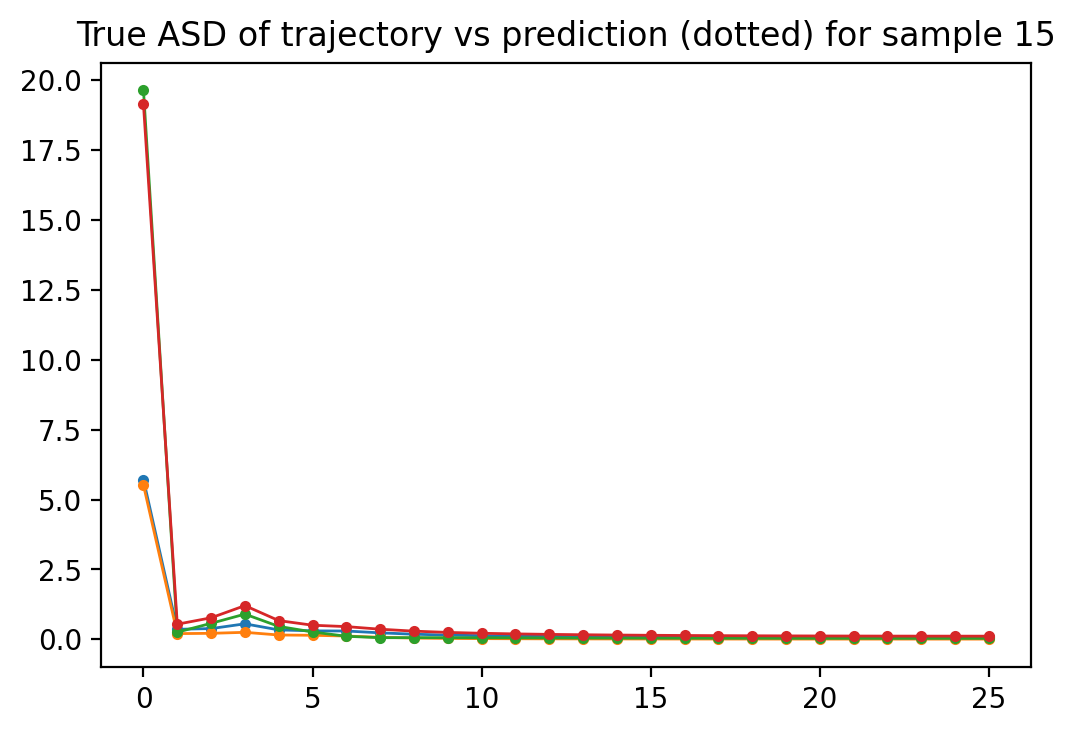

In [204]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()
i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(abs(np.fft.rfft(X_val[i][j])), color=f'C{j}', lw=1)
    plt.plot(abs(np.fft.rfft(all_preds[i][j])), ".", color=f'C{j}')
    # plt.ylim(0,1)
plt.title(f"True ASD of trajectory vs prediction (dotted) for sample {i}")
plt.show()